## The Effect of Management Training for Individual Contributors Transform to Managers

### Dataset

In [2]:
import pandas as pd
import numpy as np
np.random.seed(123)

In [3]:
df = (pd.read_csv("/content/learning_mindset.csv")
      .rename(columns={"schoolid": "departament_id",
                       "achievement_score": "engagement_score",
                       "success_expect": "tenure",
                       "school_achievement": "last_engagement_score",
                       "school_urbanicity": "role",
                       "school_poverty": "department_score",
                       "school_size": "department_size",
                       "ethnicity": "n_of_reports"})
      # reduce overlapp for better examples
      .assign(intervention = lambda d: (d["intervention"].astype(bool) | (np.random.normal(d["last_engagement_score"]) > 1.65)).astype(int))
      .assign(intervention = lambda d: (d["intervention"].astype(bool) | (np.random.normal(d["tenure"], 2) > 7)).astype(int))
      .assign(n_of_reports = lambda d: d["n_of_reports"].clip(0, 8))
      .assign(department_size = lambda d: d.groupby("departament_id")["n_of_reports"].transform(sum))
      .assign(last_engagement_score = lambda d: np.random.normal(d["last_engagement_score"]))
      .drop(columns=["frst_in_family", "school_mindset", "school_ethnic_minority"]))


df.to_csv("/content/management_training.csv", index=False)

In [4]:
df1=pd.read_csv("/content/management_training.csv")
df1.head()

departament_id  intervention  engagement_score  tenure  n_of_reports  \
0              76             1          0.277359       6             4   
1              76             1         -0.449646       4             8   
2              76             1          0.769703       6             4   
3              76             1         -0.121763       6             4   
4              76             1          1.526147       6             4   

   gender  role  last_engagement_score  department_score  department_size  
0       2     4               0.614261          0.224077              843  
1       2     4               0.069636          0.224077              843  
2       2     4               0.866918          0.224077              843  
3       2     4               0.029071          0.224077              843  
4       1     4               0.589857          0.224077              843

- `intervention`: treatment variable
- `engagement_score`: outcome of interest
  - some ICs want to engage in the activity even without being assigned, while others don't want to go to the training.
- `department_score`:average engagement score in the same department
- `last_engagement_score`:the average score for an manager in previous iteration

### Linear Regression Adjustment for Confounders

In [5]:
import statsmodels.formula.api as smf
smf.ols("engagement_score ~ intervention", data=df1).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

- The treatment is not random. We need to reduce the bias.
- $engagement_i=τT_i+\theta X_i+e_i$
  - $X$: confounders 混淆因子，即会影响到干预变量，又会影响到结果变量

In [6]:
model=smf.ols("""
              engagement_score~intervention
              +tenure+last_engagement_score+department_score+n_of_reports+C(gender)+C(role)""", #put categorical variables into C()
              data=df1).fit()
print("ATE:", model.params["intervention"])
print("95% Confident Interval", model.conf_int().loc["intervention", :].values.T)

ATE: 0.26779085766768634
95% Confident Interval [0.23357751 0.30200421]


#### Conclusions:
- Obveriously, the effect of the intervention on engagement is smaller than before.(0.26779086 < 0.4346)
- hence, there exists <u>positive bias</u>. That is, employees who were already engaged are more likely to take participation in the program.

#### ATE:
- average treatment effect全部样本的平均处理效应
  - $ATE=E[Y(T=1)-Y(T=0)]$
- ATT: Average Treatment Effect on the Treated被处理者的平均处理效应
  - 找到一个与被treated之前完全相同的sample，与做了treated之后做差
  - 我们希望用ATE无限接近于ATT，就需要清理bias

### Propensity Score Estimation

- Balance Score: conditional probability of the treatement, $P(T|X)$, namely, $e(x)$ propensity score

In [7]:
import graphviz as gr

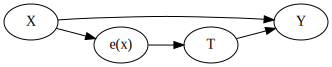

In [8]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

In [9]:
#owing to binary variable, we need to use logit regression
ps_estimate=smf.logit("""
                      intervention~tenure +
                      last_engagement_score + department_score+
                      C(n_of_reports) + C(gender) + C(role)""", data=df1).fit(disp=0) #disp=0:不显示regression的summary

In [10]:
#make the prediction
df_ps=df1.assign(propensity_score=ps_estimate.predict(df1))
df_ps.head()

departament_id  intervention  engagement_score  tenure  n_of_reports  \
0              76             1          0.277359       6             4   
1              76             1         -0.449646       4             8   
2              76             1          0.769703       6             4   
3              76             1         -0.121763       6             4   
4              76             1          1.526147       6             4   

   gender  role  last_engagement_score  department_score  department_size  \
0       2     4               0.614261          0.224077              843   
1       2     4               0.069636          0.224077              843   
2       2     4               0.866918          0.224077              843   
3       2     4               0.029071          0.224077              843   
4       1     4               0.589857          0.224077              843   

   propensity_score  
0          0.596106  
1          0.391138  
2          0.602578  
3          0.580990  
4          0.619976

### Orthogonalization

In [11]:
model1=smf.ols("""engagement_score~intervention+propensity_score""", data=df_ps).fit()
model1.params["intervention"]

0.2633126749027707

- The result is very similar to ATE estimated one.(0.2633≈0.26779) There are two alternative methods to adjust for confounders.

### Propensity Score Matching

- Get the *pairs of units* with similar observable characteristics, and compare the outcomes of who recieved the treatment to who did not
- 使用条件：
  - sample量尽可能的大，这样可以找到匹配度高的样本
  - 控制组和实验组的倾向得分有大面积的重合部分


In [12]:
#使用临近匹配
from sklearn.neighbors import KNeighborsRegressor
T="intervention"
X="propensity_score"
Y="engagement_score"
treated=df_ps.query(f"{T}==1")
untreated=df_ps.query(f"{T}==0")
m0=KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]], untreated[Y])
m1=KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[Y])
prediction=pd.concat([treated.assign(match=m0.predict(treated[[X]])),
                     untreated.assign(match=m1.predict(untreated[[X]]))])
prediction.head()

departament_id  intervention  engagement_score  tenure  n_of_reports  \
0              76             1          0.277359       6             4   
1              76             1         -0.449646       4             8   
2              76             1          0.769703       6             4   
3              76             1         -0.121763       6             4   
4              76             1          1.526147       6             4   

   gender  role  last_engagement_score  department_score  department_size  \
0       2     4               0.614261          0.224077              843   
1       2     4               0.069636          0.224077              843   
2       2     4               0.866918          0.224077              843   
3       2     4               0.029071          0.224077              843   
4       1     4               0.589857          0.224077              843   

   propensity_score     match  
0          0.596106  0.557680  
1          0.391138 -0.952622  
2          0.602578 -0.618381  
3          0.580990 -1.404962  
4          0.619976  0.000354

- 1:1对应，每个实验组的个体找到距离最近的那一个控制组的个体进行匹配。未匹配的样本remove掉
  - 最终得到匹配的样本比较小，估计方差大，bias小
- With a match of each unit, we can estimate ATE: $\widehat{ATE}=\frac{1}{N}(Y_i-Y_{jm(i)})T_i+(Y_{jm(i)}-Y_i)(1-T_i)$

In [13]:
np.mean((prediction[Y]-prediction["match"])*prediction[T]+(prediction["match"]-prediction[Y])*(1-prediction[T]))

0.28777443474045966

- Other Matching Strategies:
  -

### Inverse Propensity Weighting(IPW)
- formula:$W_i=\frac{1}{e(X_i)}, when \space T=1$处理组；$W_i=\frac{1}{1-e(X_i)},when \space T=0$对照组
  - when $e(X_i)$ is high, both of weights are high.
  - Give a high importance to the treated(untreated) that look like the untreated(treated);
- 两类样本的加权平均值之差-->平均因果效应的大小 来估算ATE
- backwards:当$e(X_i)$无限接近于0或1时，估算的weight会无限大，无法正确估计ATE。

In [14]:
# ATE estimate
weight1=1/df_ps.query('intervention==1')['propensity_score']
weight0=1/(1-df_ps.query('intervention==0')['propensity_score'])
t1=df_ps.query("intervention==1")["engagement_score"]
t0=df_ps.query("intervention==0")["engagement_score"]
y1=sum(t1*weight1)/len(df_ps)
y0=sum(t0*weight0)/len(df_ps)
print("weight1:",weight1)
print("weight0:",weight0)
print("e[Y1]:", y1)
print("e[Y0]:", y0)
print("ATE", y1-y0)

weight1: 0        1.677555
1        2.556645
2        1.659537
3        1.721201
4        1.612966
           ...   
10360    2.908216
10371    3.781455
10373    1.666140
10378    1.796676
10390    2.386631
Name: propensity_score, Length: 5611, dtype: float64
weight0: 3384     2.066716
3385     2.099618
3386     2.036585
3388     2.525249
3389     2.397136
           ...   
10385    1.795484
10386    2.489387
10387    2.690826
10388    1.276783
10389    1.878212
Name: propensity_score, Length: 4780, dtype: float64
e[Y1]: 0.11656317232946718
e[Y0]: -0.14941553647814387
ATE 0.26597870880761104


- The result above is sightly smaller than unweighted one.
- ATE simplify expression: $ATE=E[Y\frac{T-e(x)}{e(x)(1-e(x))}]$

In [15]:
# operated as the expression instructs:
np.mean(df_ps['engagement_score']*
        ((df_ps["intervention"] - df_ps["propensity_score"])
        / (df_ps["propensity_score"]*(1-df_ps["propensity_score"]))))

0.26597870880761104

- apparently, the result is the same as the previous one.

### Variance of IPW
- Randomly resampling

In [16]:
#rewrite IPW calculation in a reusable function
#sklearn is much more quicker than statsmodels
#use dmatrix to calculate covariance
from sklearn.linear_model import LogisticRegression
!pip install patsy
from patsy import dmatrix

def estimate_ATE_with_ps(data, ps_formula, T, Y):
  X=dmatrix(ps_formula, data)
  ps_model=LogisticRegression(penalty='none', max_iter=1000).fit(X, data[T])
  ps=ps_model.predict_proba(X)[:,1] #do not output binary results, we need a probability format instead.
  #The output is a two column matrix, we only want the second column, namely, when T=1.
  return np.mean((data[T]-ps)/(ps*(1-ps))*data[Y])

In [17]:
#use the function
formula="""
        C(n_of_reports)+C(gender)+C(role)+tenure+last_engagement_score+department_score
        """
T='intervention'
Y='engagement_score'
estimate_ATE_with_ps(df1, formula, T, Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.2659370590651038

In [18]:
#to speed up, we need to run the bootstrap resampling in parallel with CPU
#CI=[0.025, 0.975]
from joblib import Parallel, delayed
def bootstrap(data, estimation_function, rounds=200, seed=123, pcts=[2.5, 97.5]):
  np.random.seed(seed)
  parallel=Parallel(n_jobs=5)(delayed(estimation_function)(data.sample(frac=1, replace=True))
                              for _ in range(rounds))
  return np.percentile(parallel, pcts)

In [19]:
from toolz import partial
print(f"ATE:{estimate_ATE_with_ps(df1, formula, T, Y)}")
estimation_function=partial(estimate_ATE_with_ps, ps_formula=formula, T=T, Y=Y)
print(f"95% Confidence Interval: ", bootstrap(df1, estimation_function))

ATE:0.2659370590651038


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


95% Confidence Interval:  [0.22656548 0.30074837]


- the previous CI with linear regression is [0.23357751, 0.30200421], which is as wide as one we got above. But the new result is sightly smaller in range than previous one.
  - This is because the original data might be gathered confoundedly(not random).

### Stabilized Propensity Weights
- remove bias for IPW, avoiding weights are too large getting counterfactual result.
- use marginal probability of the treatment:
  - $w=\frac{P(T=t)}{P(T=t)|X}$
  - it reconstructs the pseudo-population, whose effect size equals to sum of weights.

In [20]:
# sum of treated and untreated weights
print('Original Sample Size: ', df_ps.shape[0])
print('Treated Pseudo-Population Sample Size: ', sum(weight1))
print('Untreated Pseudo-Population Sample Size: ', sum(weight0))

Original Sample Size:  10391
Treated Pseudo-Population Sample Size:  10435.089079197915
Untreated Pseudo-Population Sample Size:  10354.298899788308


- The reweighted sample size of two Pseudo-Populations are close to the original one.

In [21]:
t1=df_ps.query('intervention==1')
t0=df_ps.query('intervention==0')
P_t=df_ps['intervention'].mean()
weight_treated_stable=P_t/t1["propensity_score"]
weight_untreated_stable=(1-P_t)/(1-t0["propensity_score"])
print("Treat Size: ", len(t1))
print("Treated Stable Weight: ", sum(weight_treated_stable))
print("Control Size: ", len(t0))
print("Control Stable Weight: ", sum(weight_untreated_stable))

Treat Size:  5611
Treated Stable Weight:  5634.807508745978
Control Size:  4780
Control Stable Weight:  4763.116999421417


In [22]:
#try to calculate the ATE
N_t=len(t1)
N_c=len(t0)
y1=sum(t1["engagement_score"]*weight_treated_stable)/N_t
y0=sum(t0["engagement_score"]*weight_untreated_stable)/N_c
print("ATE: ", y1-y0)

ATE:  0.26597870880761065


- The Stabilization keeps **the same** ATE result as the calculation after IPW. While, the calculation process will be much more stable.

### Pseudo-Population
- Bias: some units have higher chances to be selected as treated group.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
marker=['o','v','d','p']
linestyle=['-', '--', ':', '-.']

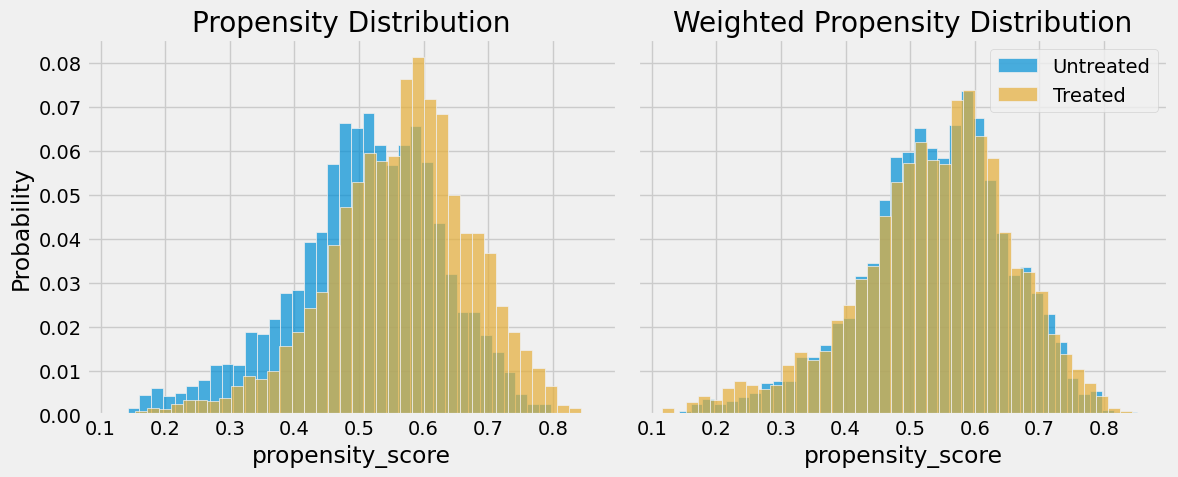

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

sns.histplot(df_ps.query("intervention==0")["propensity_score"], stat="probability",
             label="Untreated", color="C0", bins=40, ax=ax1, alpha=0.7)
sns.histplot(df_ps.query("intervention==1")["propensity_score"], stat="probability",
             label="Treated", color="C2", alpha=0.7, bins=40, ax=ax1)
ax1.set_title("Propensity Distribution")

sns.histplot(df_ps.query("intervention==0").assign(w=weight_untreated_stable),
             x="propensity_score", stat="probability",
             color="C0", weights="w", label="Untreated", bins=40, ax=ax2,  alpha=0.7)
sns.histplot(df_ps.query("intervention==1").assign(w=weight_treated_stable),
             x="propensity_score", stat="probability",
             color="C2", weights="w", label="Treated", bins=40, alpha=0.7, ax=ax2)
ax2.set_title("Weighted Propensity Distribution")
plt.legend()
plt.tight_layout()

IMG_8607.jpeg- As the second graph with IPW shows that untreated group is a little bit shifting to the right.
- After the IPW adjustment, the total variance of $e(x)$ is smaller than before.
- The overlap between treated and untreated groups are larger.The randomness gets higher than before. That is, the same chance to be choose as both treated and untreated group is the same.

### Doubly Robust Estimation(DR)
- **At least one** of model- or design-based identification is correct.
- allow us to make the estimation even when there exists <u>missing data</u>
- a combination of outcome regression and PSM
  - regression:
    - debias
    - If the confounders are misspecified in this model, the estimated effect of exposure may be biased
  - PSM:
    - estimate the treatment effect
    - If themodel is misspecified, then the weighting will be inappropriate and the IPW estimator may be biased.

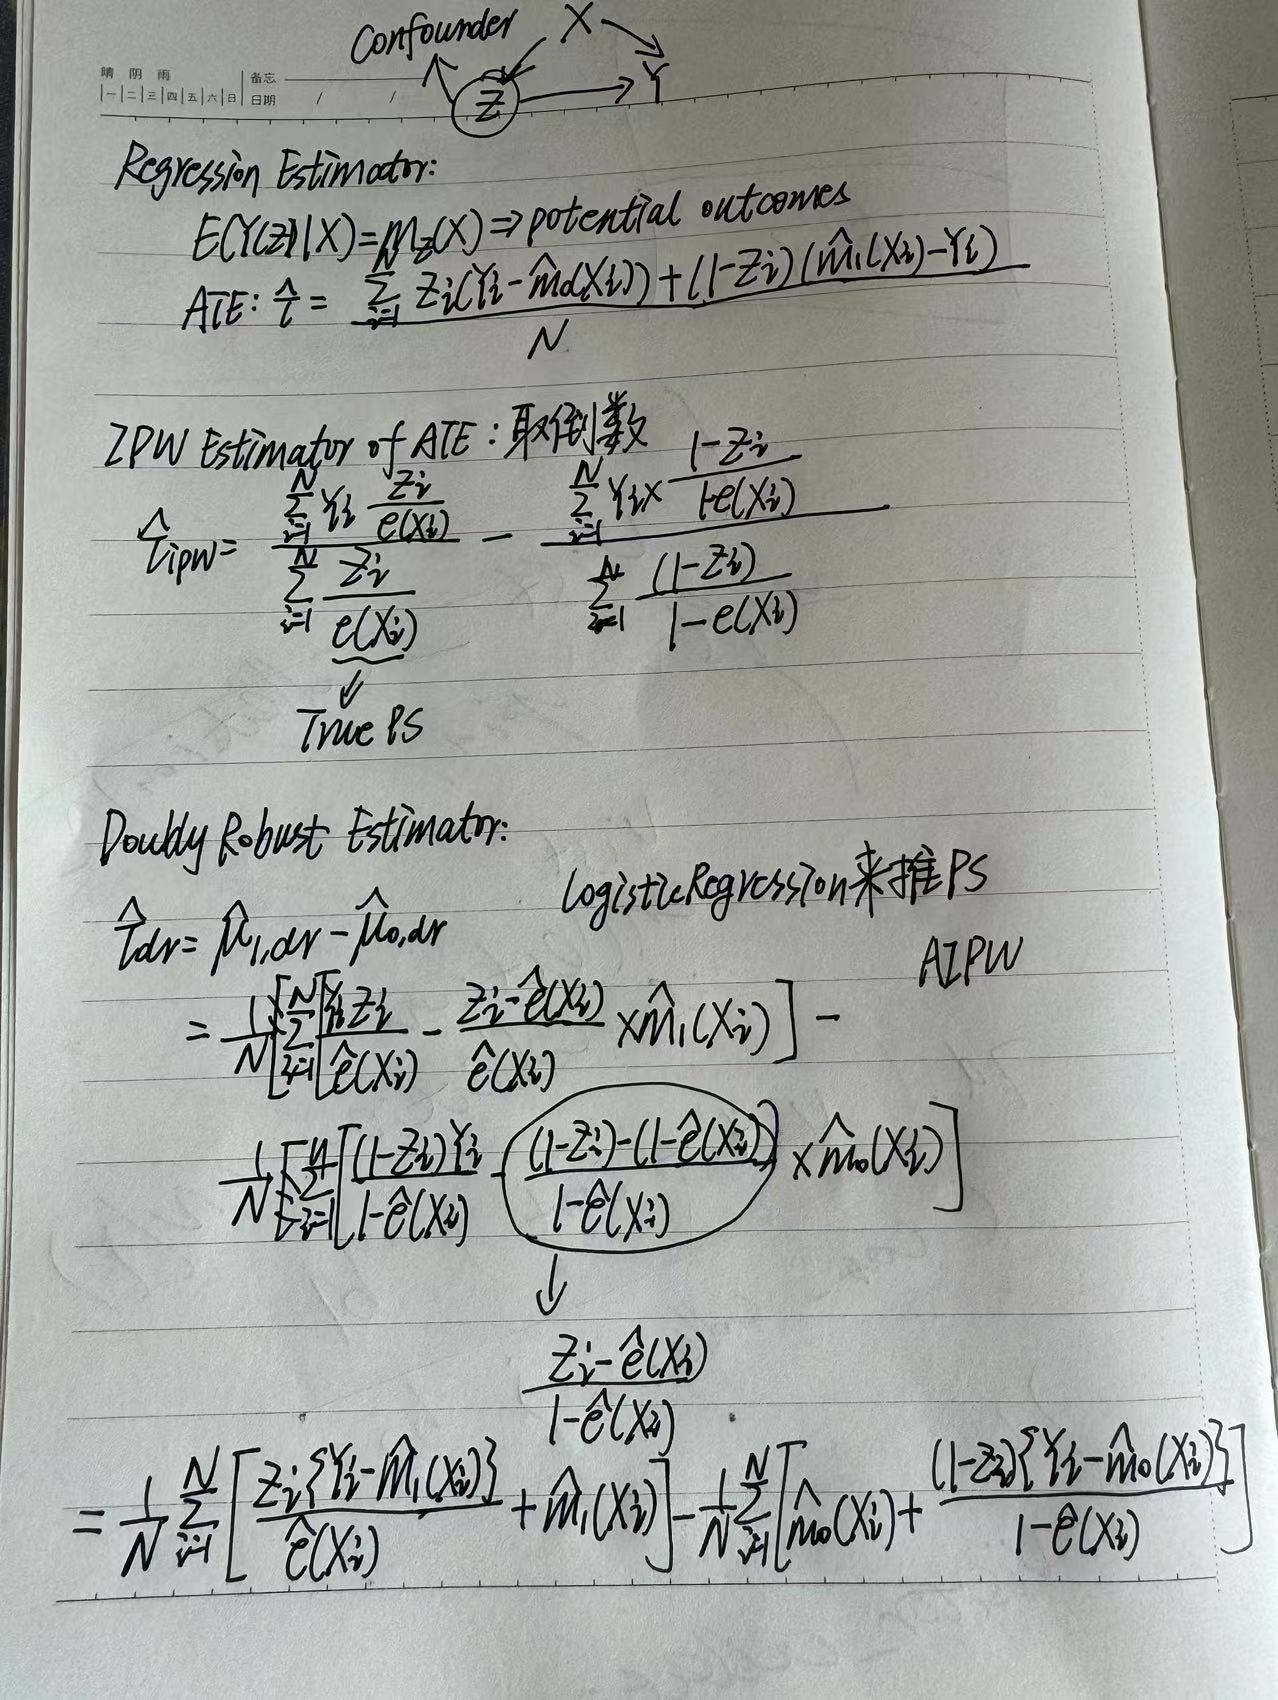

In [26]:
def doubly_robust(data, formula, T, Y):
  X=dmatrix(formula, data)
  psm=LogisticRegression(penalty='none',max_iter=1000).fit(X, data[T])
  ps=psm.predict_proba(X)[:,1]
  m0=LinearRegression().fit(X[data[T]==0,:],data.query(f'{T}==0')[Y])
  m1=LinearRegression().fit(X[data[T]==1,:],data.query(f'{T}==1')[Y])
  m0_hat=m0.predict(X)
  m1_hat=m1.predict(X)
  return (
        np.mean(data[T]*(data[Y] - m1_hat)/ps + m1_hat) -
        np.mean((1-data[T])*(data[Y] - m0_hat)/(1-ps) + m0_hat)
    )

In [27]:
formula = """tenure + last_engagement_score + department_score
+ C(n_of_reports) + C(gender) + C(role)"""
print("DR ATE:", doubly_robust(df1, formula, T, Y))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


DR ATE: 0.27116312919978613


In [28]:
#use bootstrap funtion to construct a confident interval
est_fn = partial(doubly_robust, formula=formula, T=T, Y=Y)
print("95% CI", bootstrap(df1, est_fn))

95% CI [0.23014331 0.3052468 ]


### Generalized Propensity Score for Continuous Treatment


#### Case Background Info:
- The bank is aimed to research about how loan interest rates affect the duration that customers select to pay back.
- The bank uses 2 machine learning models to assign the interest rate
- Add a Gaussian noise to decision making process of customers
- Obey the positivity assumption

In [29]:
df2=pd.read_csv('/content/interest_rate.csv')
df2.head()

ml_1      ml_2  interest  duration
0  0.392938  0.326285       7.1      12.0
1 -0.427721  0.679573       5.6      17.0
2 -0.546297  0.647309      11.1      12.0
3  0.102630 -0.264776       7.2      18.0
4  0.438938 -0.648818       9.5      19.0

- We need to debias the relationship between interest and duration and adjust confounders ml_1 and ml_2.
- Without any adjustment, we take a simple linear regression as a trial:

In [30]:
trail=smf.ols('duration~interest',data=df2).fit()
trail.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     136.8
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           2.11e-31
Time:                        06:06:34   Log-Likelihood:                -32411.
No. Observations:               10000   AIC:                         6.483e+04
Df Residuals:                    9998   BIC:                         6.484e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.5033      0.226     64.283      0.000      14.061      14.946
interest       0.3393      0.029     11.697      0.000       0.282       0.396
==============================================================================
Omnibus:                      149.791   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.172
Skew:                           0.004   Prob(JB):                     1.18e-19
Kurtosis:                       2.543   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The figure shows the the coefficients are **positive**, contrary to the expectation and our common sense.
- Subsequentaly, we **adjust the confounders**:
  - continuous variables property: $P(T=t)=0$
    - Solution: use cdf with normal distribution.

In [32]:
#get the mean(the fitted value) and standard divation(residual) of normal distribution
model=smf.ols('interest~ml_1+ml_2', data=df2).fit()

In [41]:
def cdf(x, mean, std):
  denominator=std*np.sqrt(2*np.pi)
  numerator=np.exp(-((1/2)*((x-mean)/std)**2))
  return  np.array(numerator/denominator) # return a contiguous flattened array.

In [42]:
genps=cdf(df2['interest'], model.fittedvalues, np.std(model.resid))
genps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [49]:
#alternatively, we simply use norm function to get mean and variance by scipy
from scipy.stats import norm
genps1=norm.pdf(df2['interest'],loc=model.fittedvalues, #specify the mean
            scale=np.std(model.resid)) #specify the variance
genps1
# https://scipy.github.io/devdocs/reference/generated/scipy.stats.norm.html

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

- See the effect after the adjustment
  - `Weighted Least Squares`

In [54]:
model2=smf.wls('duration~interest',data=df2,weights=1/genps1).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.143
Model:                            WLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     1670.
Date:                Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                        07:19:00   Log-Likelihood:                -35444.
No. Observations:               10000   AIC:                         7.089e+04
Df Residuals:                    9998   BIC:                         7.091e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.9965      0.141    156.456      0.000      21.721      22.272
interest      -0.6674      0.016    -40.870      0.000      -0.699      -0.635
==============================================================================
Omnibus:                     3260.764   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           322950.542
Skew:                           0.582   Prob(JB):                         0.00
Kurtosis:                      30.816   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The coefficient of interest<0

- Fit interest rate only with ml_1

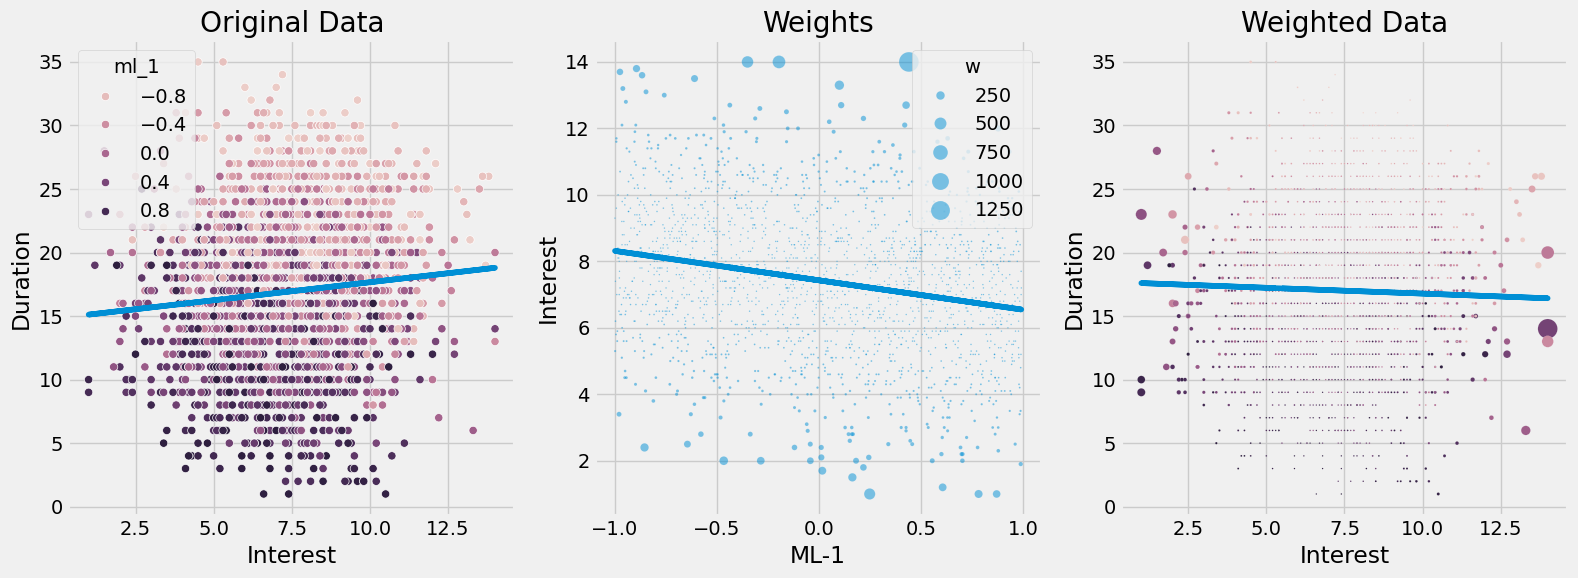

In [60]:
np.random.seed(1)
sample = df2.sample(2000)

model_ex = smf.ols("interest~ml_1", data=sample).fit()
gps_ex = norm.pdf(sample["interest"],loc=model_ex.fittedvalues, scale=np.std(model_ex.resid))
w_ex = 1/gps_ex

m = smf.ols("duration~interest", data=sample).fit()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
sns.scatterplot(data=sample, x="interest", y="duration", alpha=1, ax=ax1, hue="ml_1")
ax1.plot(sample["interest"], m.fittedvalues)
ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data")


sns.scatterplot(data=sample.assign(w=w_ex), x="ml_1", y="interest",size="w",sizes=(1,200), alpha=0.5, ax=ax2)
ax2.plot(sample["ml_1"], model_ex.fittedvalues)
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")


m = smf.wls("duration~interest", data=sample, weights=w_ex).fit()
sns.scatterplot(data=sample.assign(w=w_ex), x="interest", y="duration",size="w",
                sizes=(1,200), alpha=1, ax=ax3, hue="ml_1", legend=None)
ax3.plot(sample["interest"], m.fittedvalues)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data")

plt.tight_layout()

#### Figure1:
- Customers with low scores with ml_1 select longer duration.
- Customers with low ml_1 score choose higher interest rate.
- To sum up, an upward bias exists.

#### Figure2:
- The fitted values of the treatment model and weights
- The higher interests, the bigger weights assigned.
  - However, some weights are extremely high!对极端值敏感

#### Figure3:
- both lower and higher interest rate obtain high importance by genps, because of the **high variance**.

In [57]:
#solution: use marginal density to stablize
stabilizer = norm.pdf(df2["interest"],
                      loc=df2["interest"].mean(),
                      scale=np.std(df2["interest"] - df2["interest"].mean()))
#take stabilizer as a multiplier to ipw calculation
gipw =  stabilizer/genps

print("Original Sample Size:", len(df2))
print("Effective Stable Weights Sample Size:", sum(gipw))

Original Sample Size: 10000
Effective Stable Weights Sample Size: 9988.195951748618


Text(0.5, 1.0, 'Weighted Data')

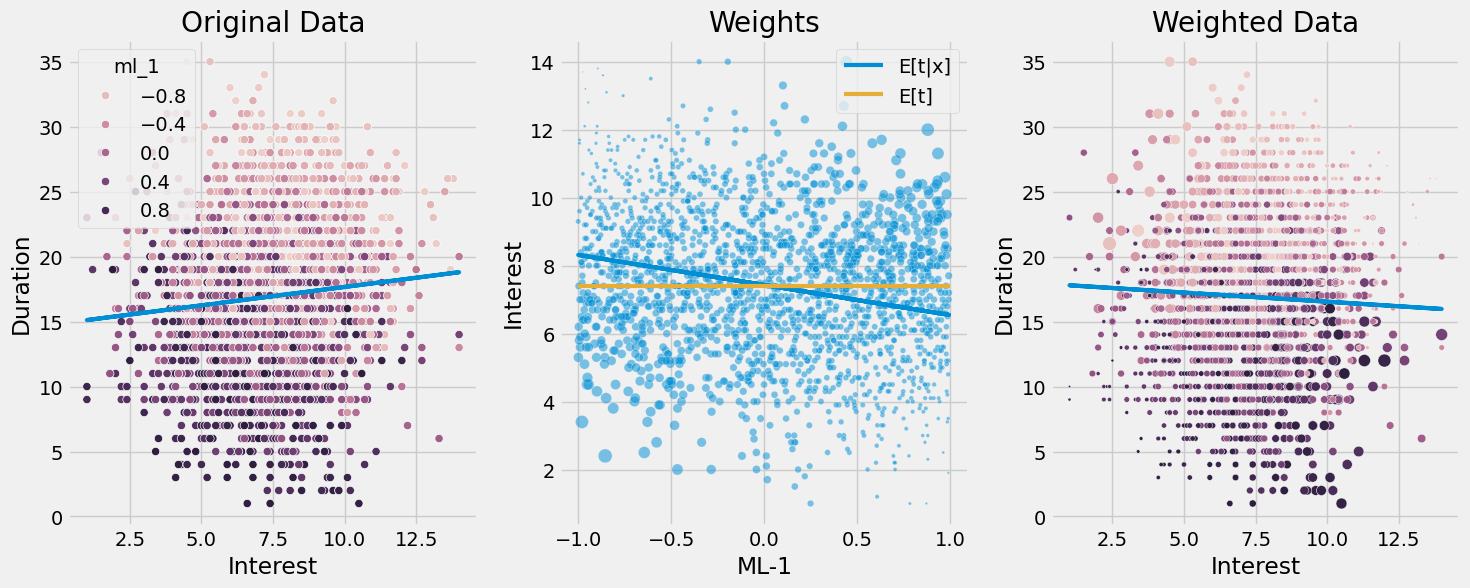

In [61]:
np.random.seed(1)
sample = df2.sample(2000)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

model_ex = smf.ols("interest~ml_1", data=sample).fit()
gps_ex = norm.pdf(sample["interest"],loc=model_ex.fittedvalues, scale=np.std(model_ex.resid))
stabilizer_ex = norm.pdf(sample["interest"],loc=sample["interest"].mean(),scale=np.std(sample["interest"] - sample["interest"].mean()))


w_ex = stabilizer_ex/gps_ex

m = smf.ols("duration~interest", data=sample).fit()
sns.scatterplot(data=sample, x="interest", y="duration", alpha=1, ax=ax1, hue="ml_1")
ax1.plot(sample["interest"], m.fittedvalues, lw=3)
ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data");


sns.scatterplot(data=sample.assign(w=w_ex), x="ml_1", y="interest",size="w",
                sizes=(1,100), alpha=0.5, ax=ax2)

ax2.plot(sample["ml_1"], model_ex.fittedvalues, label="E[t|x]", lw=3)
ax2.hlines(sample["interest"].mean(), -1, 1, label="E[t]", color="C2", lw=3)
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")
h,l = ax2.get_legend_handles_labels()
ax2.legend(h[5:],l[5:],)

m = smf.wls("duration~interest", data=sample, weights=w_ex).fit()
sns.scatterplot(data=sample.assign(w=w_ex), x="interest", y="duration",size="w",
                sizes=(1,100), alpha=1, ax=ax3, hue="ml_1", legend=None)
ax3.plot(sample["interest"], m.fittedvalues, lw=3)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data")

In [59]:
final_model = smf.wls("duration ~ interest",data=df2, weights=gipw).fit()
final_model.params["interest"]

-0.7787046278134062

### DRL with `econml`

In [100]:
!pip install econml

In [103]:
from econml.dr import DRLearner
from sklearn.metrics import mean_squared_error

In [71]:
features=df[['tenure','last_engagement_score','department_score','n_of_reports','gender','role']]
treatement=df[['intervention']]
outcome=df[['engagement_score']]

In [80]:
psmodel=LogisticRegression()
psmodel.fit(features, treatement.values.ravel())
propensity_scores=psmodel.predict_proba(features)[:,1]

regressionModel=LinearRegression()
regressionModel.fit(features, treatement.values.ravel())

LinearRegression()

In [93]:
treatment=treatement.values.ravel()
features.shape

(10391, 6)

In [104]:
print(drl.fit.__doc__)


        Estimate the counterfactual model from data, i.e. estimates function :math:`\theta(\cdot)`.

        Parameters
        ----------
        Y: (n,) vector of length n
            Outcomes for each sample
        T: (n,) vector of length n
            Treatments for each sample
        X:(n, d_x) matrix, optional
            Features for each sample
        W:(n, d_w) matrix, optional
            Controls for each sample
        sample_weight : (n,) array_like, optional
            Individual weights for each sample. If None, it assumes equal weight.
        freq_weight: (n,) array_like of int, optional
            Weight for the observation. Observation i is treated as the mean
            outcome of freq_weight[i] independent observations.
            When ``sample_var`` is not None, this should be provided.
        sample_var : (n,) nd array_like, optional
            Variance of the outcome(s) of the original freq_weight[i] observations that were used to
            compute 

In [111]:
drl=DRLearner(model_propensity=psmodel, model_regression=regressionModel)
drl.fit(outcome, treatement, X=features)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [115]:
predictions=drl.const_marginal_effect(features).ravel()

In [119]:
drl.score_

3.3507022609922634

In [116]:
mse=mean_squared_error(outcome, predictions)
print(mse)

1.1133590579052266


### Useful Python Packages
- causallib <https://github.com/BiomedSciAI/causallib> , calculate IPW directly
- psmatching <https://github.com/rlirey/psmatching>, PSM with evaluation